In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat, loadmat
from time import time

## Define function

### Generate randomwave

In [2]:
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO_complex(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.exp(1j*(k_dot_r + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def scale_rho(rho, xyz, scale):
    rho = ndimage.zoom(rho, scale, order=1)
    # r_grid = np.array([ndimage.zoom(r, scale, order=1) for r in r_grid]) 
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    x_zoom = ndimage.zoom(x, scale, order=1)
    y_zoom = ndimage.zoom(y, scale, order=1)
    z_zoom = ndimage.zoom(z, scale, order=1)
    r_grid = np.meshgrid(x_zoom,y_zoom,z_zoom)
    return rho, r_grid

### Identify vortex lines

In [3]:
## identify vortex line (slice of plane)
def vortex_slice(phase_slice):
    '''
    Input
    phase_slice: 2D array of phase field (floats, -pi to pi).

    Output
    vortex_array: 2D array of vortex locations (binary)
    ----------------------------------------------------------------
     --- --- ---
    | 1 | 8 | 7 |
    --- --- --- 
    | 2 | p | 6 |
    --- --- ---
    | 3 | 4 | 5 |
    --- --- ---
    A pixel is identified as a vortex if the phase difference along 
    the encircling path exceeds pi for an odd number of times.
    '''
    # list_cells = np.array([[-1,1], [-1,0], [-1,-1], [0,-1], [1,-1], [1,0], [1,1], [0,1]])

    vortex_array = np.zeros_like(phase_slice)
    # evaluate the phase difference
    pd_u = phase_slice[:,1:]-phase_slice[:,0:-1]
    pd_d = phase_slice[:,0:-1]-phase_slice[:,1:]
    pd_l = phase_slice[0:-1,:]-phase_slice[1:,:]
    pd_r = phase_slice[1:,:]-phase_slice[0:-1,:]

    ## vectorized
    ib_i = np.arange(phase_slice.shape[0]-2)
    ib_j = np.arange(phase_slice.shape[0]-2)
    phase_diff = np.array([pd_d[np.ix_(ib_i+1-1,ib_j+1)],pd_d[np.ix_(ib_i+1-1,ib_j)],
                           pd_r[np.ix_(ib_i,ib_j+1-1)],pd_r[np.ix_(ib_i+1,ib_j+1-1)],
                           pd_u[np.ix_(ib_i+1+1,ib_j)],pd_u[np.ix_(ib_i+1+1,ib_j+1)], 
                           pd_l[np.ix_(ib_i+1,ib_j+1+1)],pd_l[np.ix_(ib_i,ib_j+1+1)]])
    index_defect = np.sum(np.abs(phase_diff)>np.pi,axis=0)%2>0
    index_defect = np.pad(index_defect, ((1,1), (1,1)))
    vortex_array[index_defect] = 1
    
    ## for loop
    # for i in range(phase_slice.shape[0]-2):
    #     for j in range(phase_slice.shape[0]-2):
    #         # center_coord = np.array([i+1,j+1])
    #         # cells_coord = center_coord + list_cells
    #         # phase_coord = [phase_slice[k] for k in zip(*cells_coord.T)]
    #         # phase_diff = np.array([(phase_coord[(i+1)%8]-phase_coord[i%8]) for i in range(8)])
    #         phase_diff = np.array([pd_d[i+1-1,j+1],pd_d[i+1-1,j],
    #                                pd_r[i,j+1-1],pd_r[i+1,j+1-1],
    #                                pd_u[i+1+1,j],pd_u[i+1+1,j+1], 
    #                                pd_l[i+1,j+1+1],pd_l[i,j+1+1]])

    #         if np.sum(np.abs(phase_diff)>np.pi)%2>0:
    #             vortex_array[i+1,j+1] = 1

    return vortex_array

def vortex_phase(rho_phase):
    """
    Scan over the simulation cell and identify defects.

    Input:
        rho_phase: The 3D density phase array.

    Output:
        vortex_volume: The 3D array identifying defect position.
    """

    ## scanning over the simulation cell
    n_slices = rho_phase.shape[1]
    vortex_volume = np.ones_like(rho_phase)
    for ax in range(3):
        axis_slice = ax
        vortex_array_list = []
        for i in range(n_slices):
            rho_phase_slices = rho_phase.take(indices = i, axis=axis_slice)
            vortex_array = vortex_slice(rho_phase_slices)
            vortex_array_list.append(vortex_array)

        vortex_volume_ax = np.array(vortex_array_list)
        vortex_volume_ax = np.moveaxis(vortex_volume_ax,0,axis_slice)
        vortex_volume = vortex_volume*(1-vortex_volume_ax)

    vortex_volume = 1-vortex_volume

    return vortex_volume

def defect_density(vortex_volume, r_grid):
    d_voxel = r_grid[0][0,1,0]-r_grid[0][0,0,0]
    d_cell = [(r_grid[0][0,-1,0]-r_grid[0][0,0,0]),
              (r_grid[1][-1,0,0]-r_grid[1][0,0,0]),
              (r_grid[2][0,0,-1]-r_grid[2][0,0,0])] 
    sum_voxel = np.sum(vortex_volume) # total volume of defective voxels (pixel^3)
    cross_voxel = 4 # crossection of defective voxels (pixel^2)
    length = sum_voxel/cross_voxel # length of defect line (pixel)

    cell_volume = d_cell[0]*d_cell[1]*d_cell[2]
    line_density = length*d_voxel/cell_volume

    return(line_density)


### Visualization

In [4]:
def visualize_lamellar(rho_real,vortex_volume,
                       lamellar=True,isometric=False,close=False,
                       filename = './test_lamellar_vortex.png'):
    # pyvista
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[0], r_grid[1], r_grid[2])
    grid["vol"] = rho_real.flatten('F')
    mesh = grid.contour([alpha])

    grid["vol"] = vortex_volume.flatten('F')
    mesh2 = grid.contour([0.5])

    # Visualization
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600])
    pl.enable_anti_aliasing('fxaa')

    if lamellar:
        backface_params = dict(color='#303030',
                            ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                            opacity=1
                            )
        pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                    ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                    backface_params=backface_params, 
                    smooth_shading=True, 
                    opacity=1
                    )

    pl.add_mesh(mesh, opacity=0, show_scalar_bar=False)

    backface_params_defect = dict(color='#FF0000',
                        ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                        opacity=0.5
                        )
    pl.add_mesh(mesh2, show_scalar_bar=False, color='#FF0000',  
                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                backface_params=backface_params_defect, 
                smooth_shading=True, 
                opacity=0.5
                )

    if isometric:
        # camera setting
        pl.enable_parallel_projection()
        pl.camera_position = 'yz'
        pl.camera.reset_clipping_range()
    else:
        # camera setting
        pl.camera_position = 'yz'
        pl.camera.azimuth = -60.0
        pl.camera.elevation = 24.0
        pl.camera.reset_clipping_range()

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)

    pl.add_bounding_box()
    pl.show(screenshot=filename)

    if close:
        pl.close(render=False)

In [5]:
## Fig. 2 Defect density - parameter

In [6]:
## Meshgrid
n_grid = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

parameters_list = []
line_density_list = []
rho_list = []

n_sample = 8

for i_kappa in trange(21):
    ## Random wave
    sigma_k = 0.2
    kappa = 2**((i_kappa-4)/2)
    alpha = 0

    parameters = [sigma_k,kappa,alpha]
    parameters_list.append(parameters)

    print('parameters = [{:0.1f}_{:3.2f}_{:0.2f}]'.format(*parameters))

    #### Wave vector distribution ####
    scale = 5
    k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
    # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
    k_cov  = np.diagflat(k_var)

    line_density = 0
    for i in range(n_sample):
        rho = sample_wave_MO_complex(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa)

        # rho_list.append(rho)

        # ## scale the data
        # n_grid_scale = 400
        # scale_zoom = n_grid_scale/rho.shape[0]
        # rho, r_grid = scale_rho(rho, [x,y,z], scale_zoom)

        rho_phase = np.angle(rho)

        ## identify vortex_lines
        vortex_volume = vortex_phase(rho_phase)
        line_density += defect_density(vortex_volume, r_grid)

    line_density = line_density/n_sample

    line_density_list.append(line_density)

  0%|          | 0/21 [00:00<?, ?it/s]

parameters = [0.2_0.25_0.00]


  5%|▍         | 1/21 [01:15<25:01, 75.09s/it]

parameters = [0.2_0.35_0.00]


 10%|▉         | 2/21 [02:31<23:57, 75.63s/it]

parameters = [0.2_0.50_0.00]


 14%|█▍        | 3/21 [03:47<22:47, 75.98s/it]

parameters = [0.2_0.71_0.00]


 19%|█▉        | 4/21 [05:03<21:33, 76.10s/it]

parameters = [0.2_1.00_0.00]


 24%|██▍       | 5/21 [06:20<20:22, 76.38s/it]

parameters = [0.2_1.41_0.00]


 29%|██▊       | 6/21 [07:39<19:18, 77.24s/it]

parameters = [0.2_2.00_0.00]


 33%|███▎      | 7/21 [08:56<18:01, 77.27s/it]

parameters = [0.2_2.83_0.00]


 38%|███▊      | 8/21 [10:13<16:42, 77.14s/it]

parameters = [0.2_4.00_0.00]


 43%|████▎     | 9/21 [11:30<15:24, 77.06s/it]

parameters = [0.2_5.66_0.00]


 48%|████▊     | 10/21 [12:47<14:05, 76.90s/it]

parameters = [0.2_8.00_0.00]


 52%|█████▏    | 11/21 [14:03<12:46, 76.61s/it]

parameters = [0.2_11.31_0.00]


 57%|█████▋    | 12/21 [15:19<11:29, 76.64s/it]

parameters = [0.2_16.00_0.00]


 62%|██████▏   | 13/21 [16:36<10:12, 76.51s/it]

parameters = [0.2_22.63_0.00]


 67%|██████▋   | 14/21 [17:52<08:54, 76.39s/it]

parameters = [0.2_32.00_0.00]


 71%|███████▏  | 15/21 [19:08<07:38, 76.39s/it]

parameters = [0.2_45.25_0.00]


 76%|███████▌  | 16/21 [20:24<06:20, 76.17s/it]

parameters = [0.2_64.00_0.00]


 81%|████████  | 17/21 [21:39<05:03, 75.98s/it]

parameters = [0.2_90.51_0.00]


 86%|████████▌ | 18/21 [22:55<03:47, 75.91s/it]

parameters = [0.2_128.00_0.00]


 90%|█████████ | 19/21 [24:11<02:31, 75.80s/it]

parameters = [0.2_181.02_0.00]


 95%|█████████▌| 20/21 [25:26<01:15, 75.76s/it]

parameters = [0.2_256.00_0.00]


100%|██████████| 21/21 [26:42<00:00, 76.30s/it]


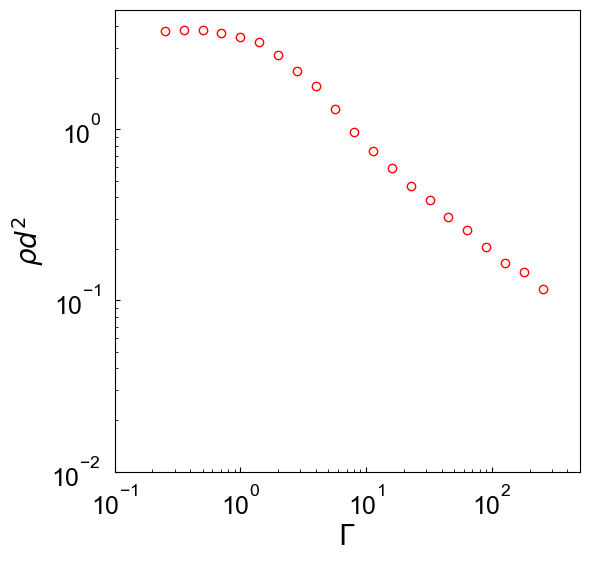

In [7]:
#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

kappa = np.array(parameters_list)[:,1]
line_density_list = np.array(line_density_list)
ax.plot(kappa,line_density_list/scale**2,'or',fillstyle='none')
    
# ax.set_xlim([0,1.5])
# ax.set_ylim([0,30])

ax.set_xlabel(r'$\Gamma$',fontsize=20)
ax.set_ylabel(r'$\rho d^2$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-1,500])
ax.set_ylim([1e-2,5])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

In [8]:
## save results
mdic = {'scale': scale,
        'line_density_list': line_density_list,
        'parameters_list': parameters_list}

filename = 'results_density_0.2.mat'
savemat(filename, mdic)

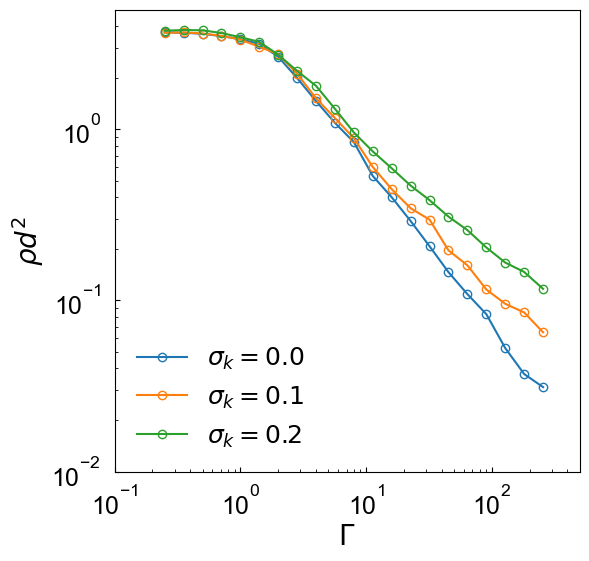

In [19]:
#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i in range(3):
    filename = 'results_density_0.{:d}.mat'.format(i)
    data = loadmat(filename)
    parameters_list = data['parameters_list']
    line_density_list = data['line_density_list'][0]

    kappa = np.array(parameters_list)[:,1]
    line_density_list = np.array(line_density_list)
    ax.plot(kappa,line_density_list/scale**2,
            '-o',fillstyle='none',label=r'$\sigma_k=0.{:d}$'.format(i))
        
    # ax.set_xlim([0,1.5])
    # ax.set_ylim([0,30])

    ax.set_xlabel(r'$\Gamma$',fontsize=20)
    ax.set_ylabel(r'$\rho d^2$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([1e-1,500])
    ax.set_ylim([1e-2,5])
    ax.legend(fontsize=18,frameon=False,loc='lower left',)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)